# HOMEWORK 5

In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from IPython.display import display, Markdown

### First Graph

In [2]:
hero_net  = pd.read_csv('hero-network.csv')

In [3]:
hero_net.drop(hero_net[hero_net['hero1'] == hero_net['hero2']].index,inplace=True)
hero_net['hero1'] = hero_net.apply(lambda  row :  row['hero1'].rstrip().rstrip('/'),axis=1)
hero_net['hero2'] = hero_net.apply(lambda  row :  row['hero2'].rstrip().rstrip('/'),axis=1)
hero_net['hero1'] = hero_net.apply(lambda row :  'SPIDER-MAN/PETER PARKER' if(row['hero1'] == 'SPIDER-MAN/PETER PAR') else row['hero1'],axis=1)
hero_net['hero2'] = hero_net.apply(lambda row :  'SPIDER-MAN/PETER PARKER' if(row['hero2'] == 'SPIDER-MAN/PETER PAR') else row['hero2'],axis=1)


In [4]:
hero_net[hero_net["hero1"] == "IRON MAN/TONY STARK"]

hero1                 hero2
18      IRON MAN/TONY STARK      FORTUNE, DOMINIC
19      IRON MAN/TONY STARK   ERWIN, CLYTEMNESTRA
457     IRON MAN/TONY STARK   WASP/JANET VAN DYNE
458     IRON MAN/TONY STARK        GALACTUS/GALAN
459     IRON MAN/TONY STARK  MOCKINGBIRD/DR. BARB
...                     ...                   ...
572762  IRON MAN/TONY STARK  YELLOWJACKET III/HEN
572763  IRON MAN/TONY STARK  CICERO, CAESAR BIG C
572764  IRON MAN/TONY STARK  SILVERMANE/SILVIO MA
573132  IRON MAN/TONY STARK  MADAME MASQUE/GIULIE
573133  IRON MAN/TONY STARK       SITWELL, JASPER

[5850 rows x 2 columns]

In [5]:
new = hero_net.groupby(['hero1','hero2']).hero2.count().reset_index(name="count")

In [55]:
G1 = nx.Graph()

In [56]:
new.apply(lambda row :  G1.add_edge(row['hero1'],row['hero2'],weight=1/row['count']),axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
224094    None
224095    None
224096    None
224097    None
224098    None
Length: 224099, dtype: object

In [8]:
nx.info(G1)

C:\Users\Fedes\AppData\Local\Temp\ipykernel_22316\968434106.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G1)


'Graph with 6426 nodes and 167207 edges'

### Second Graph

In [9]:
nodes  = pd.read_csv('nodes.csv')

In [9]:
edges  =pd.read_csv('edges.csv')

In [10]:
G2 = nx.Graph()

In [11]:
edges.apply(lambda row :  G2.add_edge(row['hero'],row['comic']),axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
96099    None
96100    None
96101    None
96102    None
96103    None
Length: 96104, dtype: object

In [20]:
nx.info(G2)

C:\Users\Fedes\AppData\Local\Temp\ipykernel_19764\1976782796.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G2)


'Graph with 19090 nodes and 96104 edges'

## Q4

We start by defining the function to reduce the graph to the top *N* heores.

In [10]:
def graph_n(graph:nx.Graph, N=None):
    """ Function to redute the graph to only the top N heroes """
    if N is None:
        return graph
    edges = pd.read_csv("edges.csv")
    h = edges.groupby("hero").count()   # extract the top n heroes
    
    top_n = h.sort_values(by="comic", ascending=False).head(N).index  # to a list
    n = edges[edges.hero.isin(top_n)]["comic"].to_list() # comic nodes that are linked to those heroes
    new_graph = graph.subgraph(top_n.to_list() + n).copy()    # create a subgraph based on the list
    return new_graph

Then we leverage it in the *function_4* in order to disconnect the graph given heroA and heroB as inputs.

In [12]:
def function_4(graph:nx.Graph, heroA, heroB, N=None, edges=False):
    """ Returns minimum set of links to disconnect heroA and heroB"""
    G = graph_n(graph, N)
    cut_set = nx.minimum_edge_cut(G, heroA.upper(), heroB.upper())
    if edges:
        return cut_set  # return the list of edges
    return len(cut_set) # return the number of edges

Trying the function with top 100 heroes:

In [27]:
function_4(G1,"CAPTAIN AMERICA","MR. FANTASTIC/REED R", 100)

78

## Q4 - visualization

For an easier representation we consider only the top 100 heroes.

In [41]:
original_graph = graph_n(G1,100)

edges = function_4(G1,"CAPTAIN AMERICA","MR. FANTASTIC/REED R", 100, edges=True)    # Find edges to remove

new_graph = original_graph.copy()    # Create new graph with the edges removed
new_graph.remove_edges_from(edges)
pos = nx.random_layout(new_graph)

The plot shows the graph before and after removing the edges.\
The number of edges removed is displayed above.

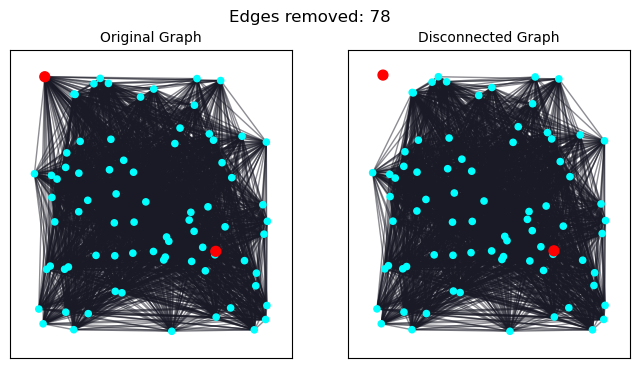

In [83]:
fig, ax = plt.subplots(1, 2, num=1, figsize=(8,4))

# Original graph with colors
color_o = ["red" if node in ["CAPTAIN AMERICA","MR. FANTASTIC/REED R"] else "cyan" for node in list(original_graph.nodes)]
size_o = [[50 if node in ["CAPTAIN AMERICA","MR. FANTASTIC/REED R"] else 20 for node in list(original_graph.nodes)]]

plt.suptitle(f"Edges removed: {len(edges)}\n")

plt.sca(ax[0])
ax[0].set_title("Original Graph", fontsize=10)
nx.draw_networkx(original_graph, pos=pos, node_size=size_o, edge_color=(.102, .102, .153, .5), with_labels=False, node_color=color_o)

# New disconnected graph
color_n = ["red" if node in ["CAPTAIN AMERICA","MR. FANTASTIC/REED R"] else "cyan" for node in list(new_graph.nodes)]
size_n = [[50 if node in ["CAPTAIN AMERICA","MR. FANTASTIC/REED R"] else 20 for node in list(new_graph.nodes)]]

plt.sca(ax[1])
ax[1].set_title("Disconnected Graph", fontsize=10)
nx.draw_networkx(new_graph, pos=pos, node_size=size_n, edge_color=(.102, .102, .153, .5), with_labels=False, node_color=color_n)


# Q5

In [83]:
def girvan_newman(graph:nx.Graph, n_comunities=2) -> tuple[int, list]:
    """Implementation of the Girvan-Newman algorithm based on EBC"""
    counter = 0
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    while(sg_count < n_comunities):   # While the graph is connected (or with less communities than expected)

        cent = nx.edge_betweenness_centrality(graph)   # Compute EBC
        node_1, node_2 = sorted(cent.items(), key=lambda item: item[1], reverse = True)[0][0]    # Take the edge with highest EBC
        graph.remove_edge(node_1, node_2)   # Remove the edge
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)    # Check the components
        counter += 1 
    c = [community for community in nx.connected_components(graph)]
    return counter, c

In [82]:
def function_5(graph:nx.Graph, Hero_1, Hero_2, N=None, n_comunities=2) -> tuple[int, list, bool]:
    is_same_group = False
    n, comunities = girvan_newman(graph, n_comunities)
    for c in comunities:
        if Hero_1 in c and Hero_2 in c:
            is_same_group = True
            break
    return n, comunities, is_same_group

In [78]:
G = graph_n(G1,1000)

In [14]:
n,c,same = function_5(G.copy(), "CAPTAIN AMERICA", "IRON MAN/TONY STARK")

In [17]:
print("Are they in the same community?", same)
print("Number of nodes to be removed:", n)

Are they in the same community? True
Number of nodes to be removed: 6


In [106]:
#np.save("c.npy",c)

# Q5 Visual

For this visualization we consider a subset of the top 1000 heroes of Graph 1.\
We chose *Captain America* and *Ironman* as input heroes:

In [ ]:
G = graph_n(G1,1000)
n,c,same = function_5(G.copy(), "CAPTAIN AMERICA", "IRON MAN/TONY STARK")

#### Number of links and communities

In [85]:
table = '| Number of links to be removed |\n'
table += '|-----|\n'
table += str(n)
display(Markdown(table))

table = '| Are the input heroes in the same community? |\n'
table += '|-----|\n'
table += "Yes" if same else "No"
display(Markdown(table))

| Number of links to be removed |
|-----|
6

| Are the input heroes in the same community? |
|-----|
Yes

Community 1:

In [ ]:
df = pd.DataFrame(c[0], columns=["Community 1"])
df

Community 2:

In [81]:
df2 = pd.DataFrame(c[1], columns=["Community 2"])
df2

Community 2
0       FROST, CARMILLA
1              M'SHULLA
2  KILLRAVEN/JONATHAN R
3                 SABRE
4             OLD SKULL

#### Graph Visualization

The first graph consist of the Original G graph but **colored** to **highlight the communities**.

The bigger points are the *Input heores*.\
It is plain to see that they belong to the same community, in accordance to what was found by the *function_5*.

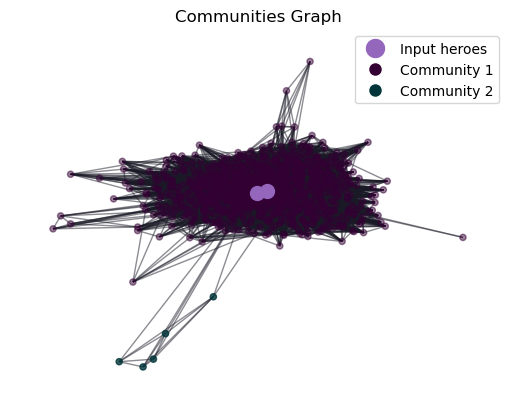

In [178]:
color_n = [(.102,.0,.51,1) if node in ["CAPTAIN AMERICA","IRON MAN/TONY STARK"] else (.204, .0, .204,.5) if node in c[0] else (.0, .208, .225,.8) for node in G.nodes()]
size_n = [[100 if node in ["CAPTAIN AMERICA","IRON MAN/TONY STARK"] else 1 for node in list(G.nodes)]]
labels = {node:("CAPTAIN AMERICA" if node == "CAPTAIN AMERICA" else "IRON MAN" if node == "IRON MAN/TONY STARK" else "") for node in G.nodes()}
#pos = nx.spring_layout(G)


plt.title("Communities Graph")
legend = [Line2D([0],[0],marker="o", color='w' , markerfacecolor="tab:purple",label="Input heroes", markersize=15),
           Line2D([0],[0],marker="o", color='w', markerfacecolor=(.204, .0, .204, 1) , label="Community 1", markersize=10),
           Line2D([0],[0],marker="o", color='w', markerfacecolor=(.0, .208, .225, 1) , label="Community 2", markersize=10)]
plt.legend(handles=legend)
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=20, edge_color=(.102, .102, .153, .5), with_labels=False, node_color=color_n, labels=labels)
nx.draw_networkx(G.subgraph(["CAPTAIN AMERICA","IRON MAN/TONY STARK"]), pos=pos, node_size=100, edge_color=(.102, .102, .153, .5), with_labels=False, node_color="tab:purple")

Below the single representation of each community:

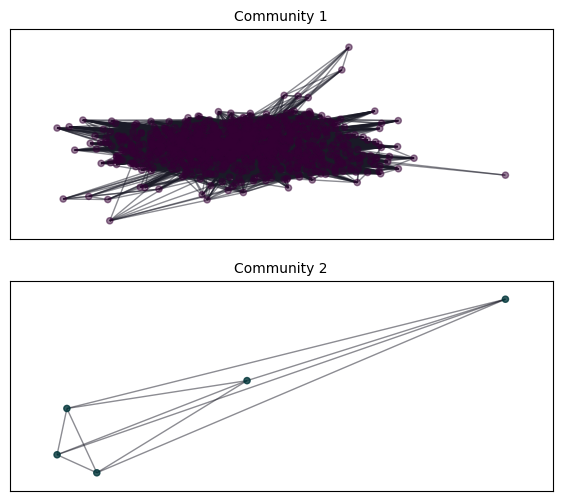

In [29]:
fig, ax = plt.subplots(2, 1, num=1, figsize=(7,6))
#pos = nx.spring_layout(G)

# Firt community
col = [(.204, .0, .204,.5) for node in c[0]]
plt.sca(ax[0])
ax[0].invert_xaxis()
ax[0].set_title("Community 1", fontsize=10)
nx.draw_networkx(G.subgraph(c[0]), pos=pos, node_size=20, edge_color=(.102, .102, .153, .5), with_labels=False, node_color=col)

# New disconnected graph
col_2 = [(.0, .208, .225,.8) for node in c[1]]
plt.sca(ax[1])
ax[1].invert_xaxis()
ax[1].invert_yaxis()
ax[1].set_title("Community 2", fontsize=10)
nx.draw_networkx(G.subgraph(c[1]), pos=pos, node_size=20, edge_color=(.102, .102, .153, .5), with_labels=False, node_color=col_2)

### Utils:

In [ ]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open("pos.json","w") as f:
    json.dump(pos,f, cls=NumpyEncoder)

#with open("pos.json", "r") as f:
#    restored_pos = json.load(f)